In [53]:
import pandas as pd
import json
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import roc_curve, classification_report, auc
import numpy as np

In [2]:
os.getcwd()

'/Users/hamza/Code/CS5914/project/analysis'

# Similarity Score Utils

In [3]:
model = SentenceTransformer('all-MiniLM-L6-v2')

def compute_similarity(output, ground):
    # Embed
    emb_ground = model.encode(ground, convert_to_tensor=True)
    emb_completion = model.encode(output, convert_to_tensor=True)

    # Cosine similarity
    score = util.cos_sim(emb_ground, emb_completion).item()

    return score

In [4]:
def add_similarity_scores(df):
    similarities = []
    
    for idx, row in df.iterrows():
        completion = row['completion'].split()
        ground = row['ground'].split()
    
        effective_ground = ground[:len(completion)]
    
        completion = ' '.join(completion)
        effective_ground = ' '.join(effective_ground)
        
        similarity = compute_similarity(completion, effective_ground)
        similarities.append(similarity)

    df['similarity'] = similarities
    return df

# News & Temperature

## Read Data

In [5]:
NEWS_TEMPERATURE_FILES = [
    '../completions/chunked-news-completions-temperature-0.1.jsonl',
    '../completions/chunked-news-completions-temperature-0.5.jsonl',
    '../completions/chunked-news-completions-temperature-1.jsonl'
]

In [23]:
news_completions = []
for file in NEWS_TEMPERATURE_FILES:
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            news_completions.append(json.loads(line))

In [24]:
news_completions = pd.DataFrame(news_completions)
news_completions.head()

,title,date,url,type,context_length,input,ground,completion,temperature,prompt
0,King Charles to receive new sword at Scottish ...,20230630,https://www.bbc.com/news/uk-scotland-glasgow-w...,before,254,A new sword will be presented to King Charles ...,incredible honour to carry the Elizabeth Sword...,honour and a privilege to carry the Elizabeth ...,0.1,You are an assistant that cites source materia...
1,Florida murder suspect arrested after 40 years,20230630,https://www.bbc.com/news/world-us-canada-66073441,before,205,A Florida murder suspect who featured thrice o...,"to Texas, California and even as far as Thaila...",across multiple states and even internationall...,0.1,You are an assistant that cites source materia...
2,The white roofs cooling women's homes in India...,20230628,https://www.bbc.com/future/article/20230628-th...,before,1352,Extreme heat is having a detrimental impact on...,to study indoors during the afternoon (Credit:...,to focus on their studies and daily activities...,0.1,You are an assistant that cites source materia...
3,Australia legalises psychedelics for mental he...,20230630,https://www.bbc.com/news/world-australia-66072427,before,297,Australia has become the first country in the ...,likely have three treatments over five to eigh...,"""be in a controlled environment with a therapi...",0.1,You are an assistant that cites source materia...
4,Chinese spy balloon did not collect informatio...,20230629,https://www.bbc.com/news/world-us-canada-66062562,before,142,The Chinese balloon that crossed the continent...,Wall Street Journal report that American-made ...,specific timeline for when the balloon was fir...,0.1,You are an assistant that cites source materia...


## Compute Similarity

In [27]:
news_completions = add_similarity_scores(news_completions)

In [28]:
news_completions['type'] = news_completions['type'].map({'before': 'member', 'after': 'non-member'})

## Analysis

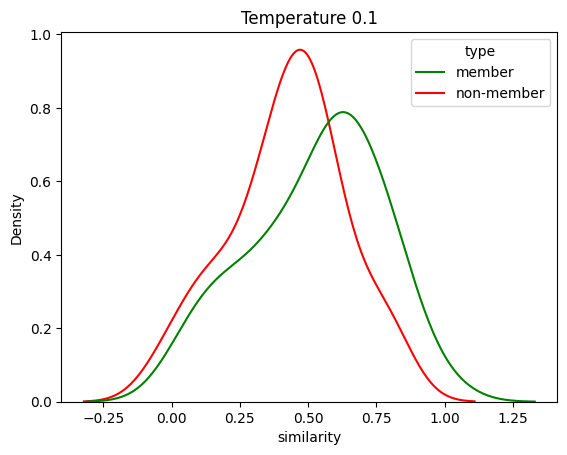

In [10]:
sns.kdeplot(data=news_completions[news_completions['temperature'] == 0.1], x="similarity", hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.title(f'Temperature {0.1}')
plt.show()

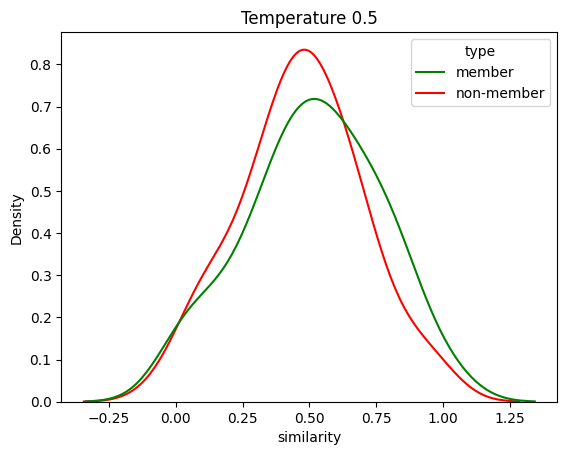

In [11]:
sns.kdeplot(data=news_completions[news_completions['temperature'] == 0.5], x="similarity", hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.title(f'Temperature {0.5}')
plt.show()

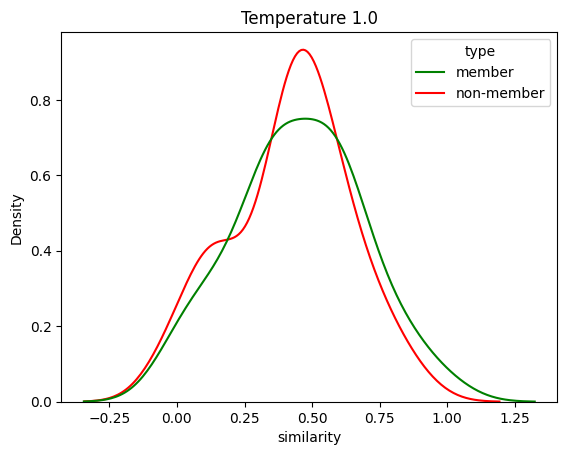

In [12]:
sns.kdeplot(data=news_completions[news_completions['temperature'] == 1], x="similarity", hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.title(f'Temperature {1.0}')
plt.show()

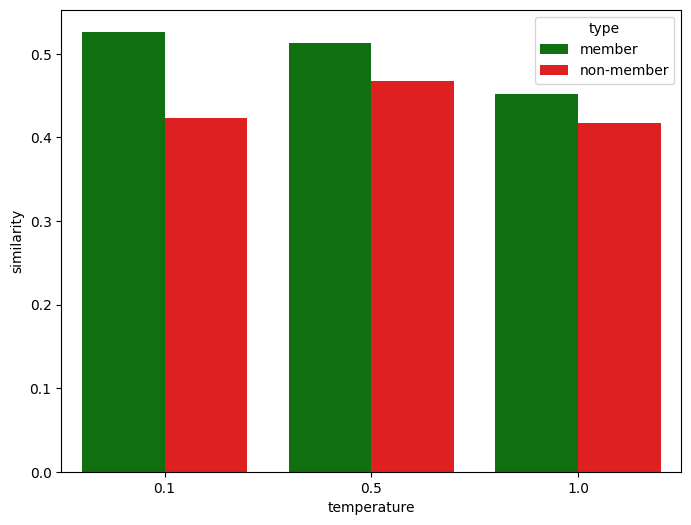

In [13]:
x = news_completions.groupby(['type', 'temperature']).mean('similarity').reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x, x='temperature', y='similarity', hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.show()

## ROC Curve

In [54]:
df = news_completions.copy()
df['y_true'] = df['type'].map({'member': 1, 'non-member': 0})

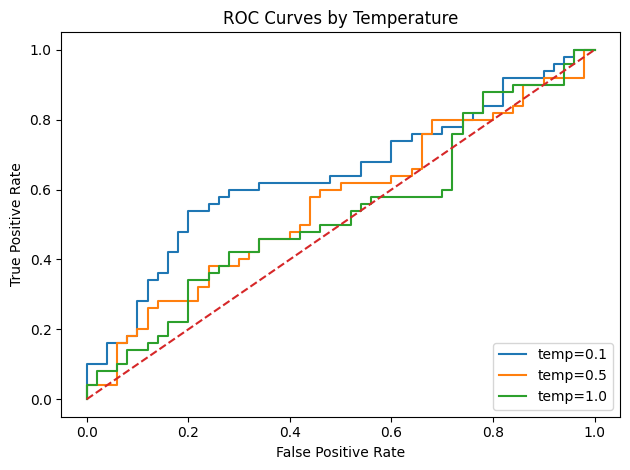

In [61]:
plt.figure()

auc_values = {}

for temp in sorted(df['temperature'].unique()):
    sub = df[df['temperature'] == temp]
    y_true  = sub['y_true']
    y_score = sub['similarity']
    
    fpr, tpr, _ = roc_curve(y_true, y_score)

    roc_auc = auc(fpr, tpr)
    auc_values[float(temp)] = float(roc_auc)

    
    plt.plot(fpr, tpr, label=f"temp={temp}")

# 4. Format the plot
plt.plot([0, 1], [0, 1], linestyle='--')     # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Temperature')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [62]:
auc_values

{0.1: 0.6416000000000001, 0.5: 0.5604, 1.0: 0.532}

In [31]:
df = news_completions.copy()
df = df[df['temperature'] == 0.1]
df['y_true'] = df['type'].map({'member': 1, 'non-member': 0})

In [35]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
j_scores = tpr - fpr
ix = np.argmax(j_scores)
best_thresh = thresholds[ix]

# print(f"Optimal threshold (max J = {j_scores[ix]:.3f}): {best_thresh:.4f}")


y_pred = (y_score >= best_thresh).astype(int)

print(classification_report(
    y_true, 
    y_pred, 
    target_names=['non-member', 'member']
))

              precision    recall  f1-score   support

  non-member       0.55      0.80      0.65        50
      member       0.63      0.34      0.44        50

    accuracy                           0.57       100
   macro avg       0.59      0.57      0.55       100
weighted avg       0.59      0.57      0.55       100



## Conclusion

A temperature of 0.1 seems to perform the best.

# Papers & Context Length

## Read Data

In [63]:
PAPERS_CONTEXTLENGTH_FILES = [
    '../completions/chunked-papers-completions-temperature-0.5.jsonl'
]

In [64]:
papers_completions = []
for file in PAPERS_CONTEXTLENGTH_FILES:
    with open(file, 'r') as f:
        for line in f:
            line = line.strip()
            papers_completions.append(json.loads(line))

In [65]:
papers_completions = pd.DataFrame(papers_completions)
papers_completions.head()

,id,title,authors,abstract,published,type,context_length,input,ground,completion,temperature,prompt
0,1709.01507,Squeeze-and-Excitation Networks,"[Jie Hu, Li Shen, Samuel Albanie, Gang Sun, En...",The central building block of convolutional ne...,2017-09-05T17:42:13+00:00,before,1024,9 1 0 2 y a M 6 1 ] V C . s c [ 4 v 7 0 5 1 0 ...,slight increase in model complexity and comput...,slight increase in model complexity and comput...,0.5,You are an assistant that uses source material...
1,1709.01507,Squeeze-and-Excitation Networks,"[Jie Hu, Li Shen, Samuel Albanie, Gang Sun, En...",The central building block of convolutional ne...,2017-09-05T17:42:13+00:00,before,2048,9 1 0 2 y a M 6 1 ] V C . s c [ 4 v 7 0 5 1 0 ...,enhanced by explicitly mod- elling channel int...,more successful if complementary channel infor...,0.5,You are an assistant that uses source material...
2,1709.01507,Squeeze-and-Excitation Networks,"[Jie Hu, Li Shen, Samuel Albanie, Gang Sun, En...",The central building block of convolutional ne...,2017-09-05T17:42:13+00:00,before,4096,9 1 0 2 y a M 6 1 ] V C . s c [ 4 v 7 0 5 1 0 ...,model architectures. 5.1 Image Classiﬁcation T...,models. We begin by describing the experimenta...,0.5,You are an assistant that uses source material...
3,1801.04381,MobileNetV2: Inverted Residuals and Linear Bot...,"[Mark Sandler, Andrew Howard, Menglong Zhu, An...",In this paper we describe a new mobile archite...,2018-01-13T04:46:26+00:00,before,1024,9 1 0 2 r a M 1 2 ] V C . s c [ 4 v 1 8 3 4 0 ...,computation compared to traditional layers by ...,the computation cost to a fraction of the orig...,0.5,You are an assistant that uses source material...
4,1801.04381,MobileNetV2: Inverted Residuals and Linear Bot...,"[Mark Sandler, Andrew Howard, Menglong Zhu, An...",In this paper we describe a new mobile archite...,2018-01-13T04:46:26+00:00,before,2048,9 1 0 2 r a M 1 2 ] V C . s c [ 4 v 1 8 3 4 0 ...,3We note that in the presence of shortcuts the...,This is different from the traditional residua...,0.5,You are an assistant that uses source material...


## Compute Similarities

In [66]:
papers_completions = add_similarity_scores(papers_completions)

In [67]:
papers_completions['type'] = papers_completions['type'].map({'before': 'member', 'after': 'non-member'})

## Analysis

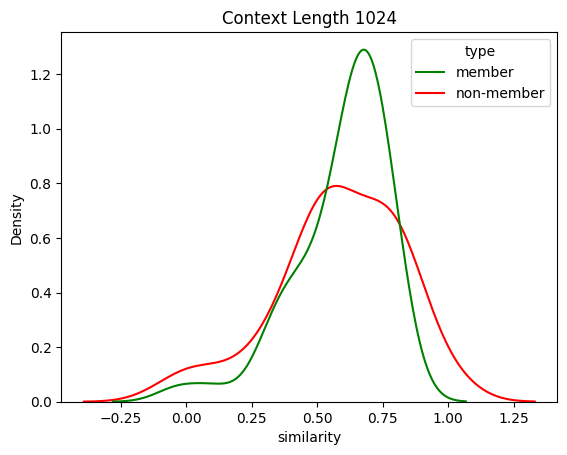

In [68]:
sns.kdeplot(data=papers_completions[papers_completions['context_length'] == 1024], x="similarity", hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.title(f'Context Length {1024}')
plt.show()

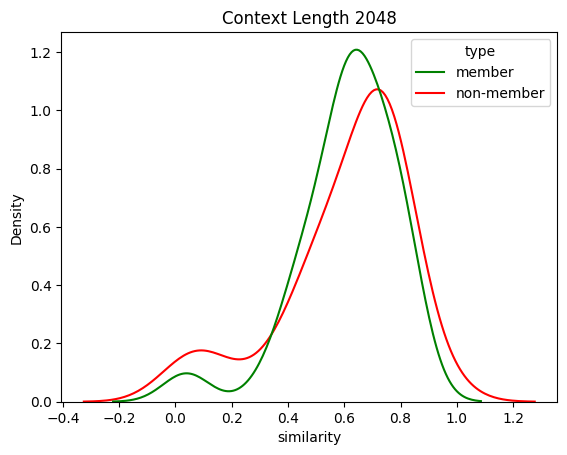

In [69]:
sns.kdeplot(data=papers_completions[papers_completions['context_length'] == 2048], x="similarity", hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.title(f'Context Length {2048}')
plt.show()

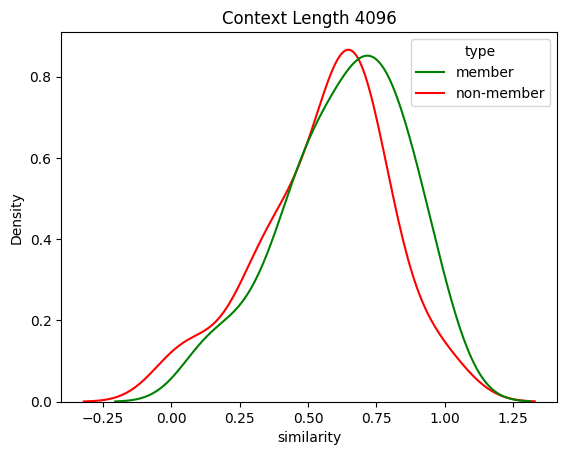

In [70]:
sns.kdeplot(data=papers_completions[papers_completions['context_length'] == 4096], x="similarity", hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.title(f'Context Length {4096}')
plt.show()

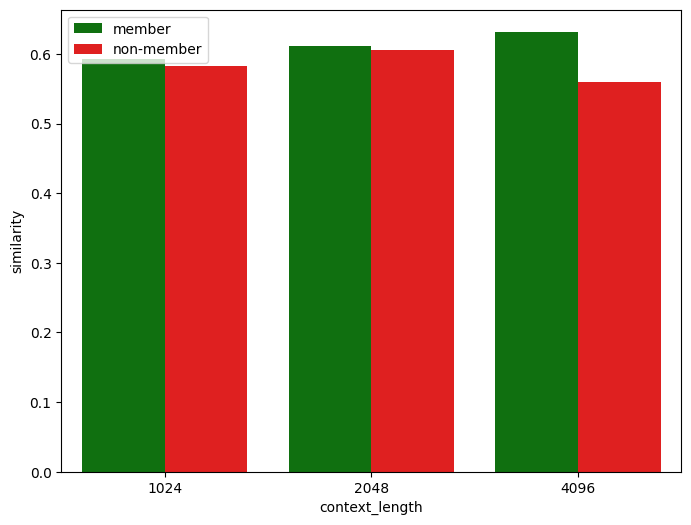

In [71]:
plt.figure(figsize=(8, 6))
x = papers_completions.groupby(['type', 'context_length']).mean('similarity').reset_index()
sns.barplot(x, x='context_length', y='similarity', hue='type', palette={'member': 'green', 'non-member': 'red'})
plt.legend(loc='upper left')
plt.show()

## ROC Curve

In [72]:
df = papers_completions.copy()
df['y_true'] = df['type'].map({'member': 1, 'non-member': 0})

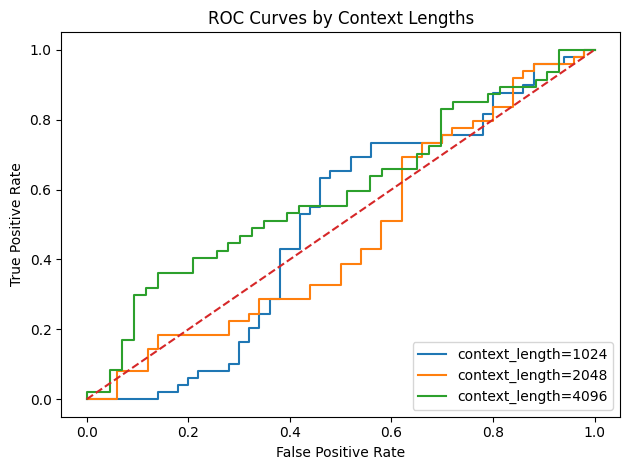

In [73]:
auc_values = {}

plt.figure()
for temp in sorted(df['context_length'].unique()):
    sub = df[df['context_length'] == temp]
    y_true  = sub['y_true']
    y_score = sub['similarity']
    
    fpr, tpr, _ = roc_curve(y_true, y_score)

    roc_auc = auc(fpr, tpr)
    auc_values[float(temp)] = float(roc_auc)
    
    plt.plot(fpr, tpr, label=f"context_length={temp}")

# 4. Format the plot
plt.plot([0, 1], [0, 1], linestyle='--')     # diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Context Lengths')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [74]:
auc_values

{1024.0: 0.5, 2048.0: 0.47061224489795916, 4096.0: 0.5912914398812469}

In [47]:
df = news_completions.copy()
df = df[df['context_length'] == 4096]
df['y_true'] = df['type'].map({'member': 1, 'non-member': 0})

In [48]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
j_scores = tpr - fpr
ix = np.argmax(j_scores)
best_thresh = thresholds[ix]

# print(f"Optimal threshold (max J = {j_scores[ix]:.3f}): {best_thresh:.4f}")


y_pred = (y_score >= best_thresh).astype(int)

print(classification_report(
    y_true, 
    y_pred, 
    target_names=['non-member', 'member']
))

              precision    recall  f1-score   support

  non-member       0.55      0.86      0.67        43
      member       0.74      0.36      0.49        47

    accuracy                           0.60        90
   macro avg       0.65      0.61      0.58        90
weighted avg       0.65      0.60      0.58        90

